In [4]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

from clearn.utils.utils import get_latent_vector_column, show_all_variables
from clearn.config.common_path import get_encoded_csv_file
import tensorflow as tf
from clearn.models.generative_models.vae import VAE
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment
from clearn.analysis.encode_decode import decode

%matplotlib inline


In [2]:
ROOT_PATH = "/Users/sunilkumar/concept_learning/image_classification_5epoch/"
config1 = ExperimentConfig(ROOT_PATH, 4, 10, [64, 128, 32])
config2 = ExperimentConfig(ROOT_PATH, 4, 5, [64, 128, 32])
exp_config = config1
N_3 = exp_config.num_units[exp_config.num_decoder_layer - 2]
N_2 = exp_config.num_units[exp_config.num_decoder_layer - 3]
Z_DIM = exp_config.Z_DIM
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name
filename  = get_encoded_csv_file(N_2, N_3, Z_DIM, "train")
mean_col_names, sigma_col_names, z_col_names = get_latent_vector_column(Z_DIM)

In [3]:
run_ids = [1,2,3,4,5]
latent_vectors = []
for run_id in run_ids:
    #exp = Experiment(1, "VAE_MNIST", 128, exp_config, run_id)
    exp_config.create_directories(run_id)
    df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
    z_min = df[z_col_names].min().min()
    z_max = df[z_col_names].max().max()
    latent_vectors.append(df[z_col_names].values)
    print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))


run_id=1 z_min=-4.3064766 z_max=5.1335334999999995
run_id=2 z_min=-4.2618922999999995 z_max=4.628557700000001
run_id=3 z_min=-4.971367 z_max=5.298665
run_id=4 z_min=-4.5266779999999995 z_max=4.7708697
run_id=5 z_min=-4.9595013 z_max=4.570926


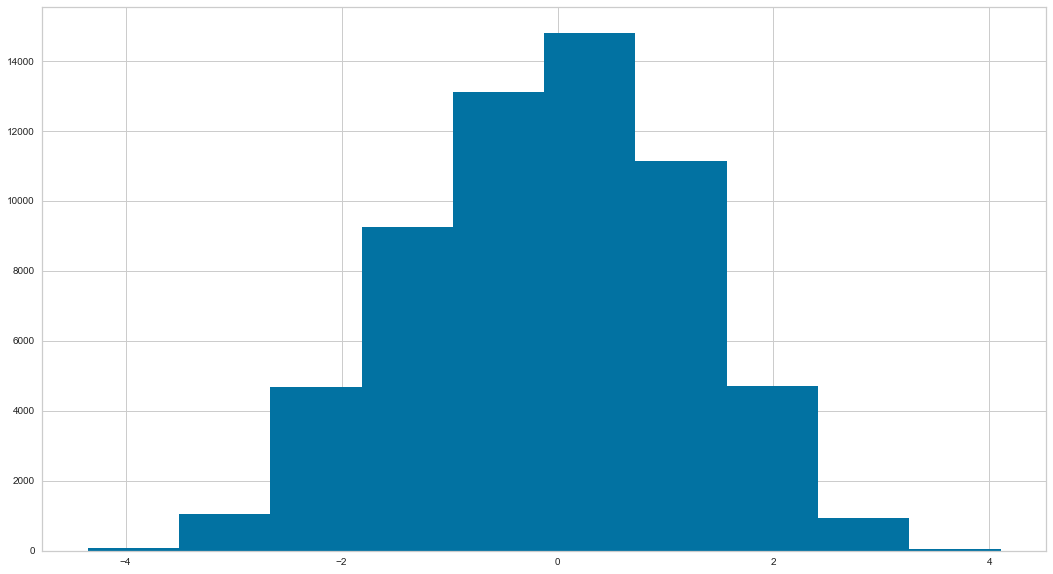

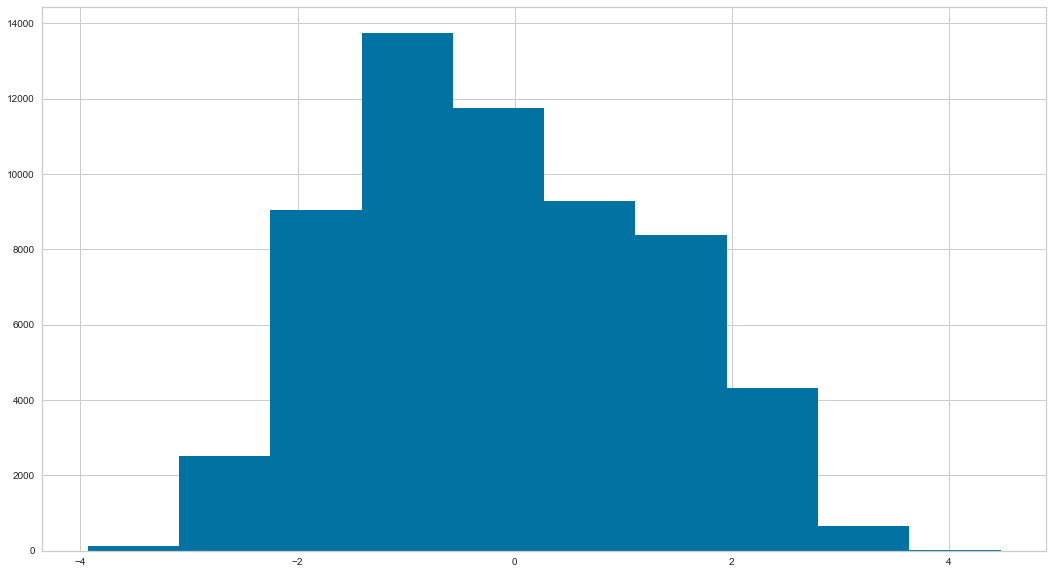

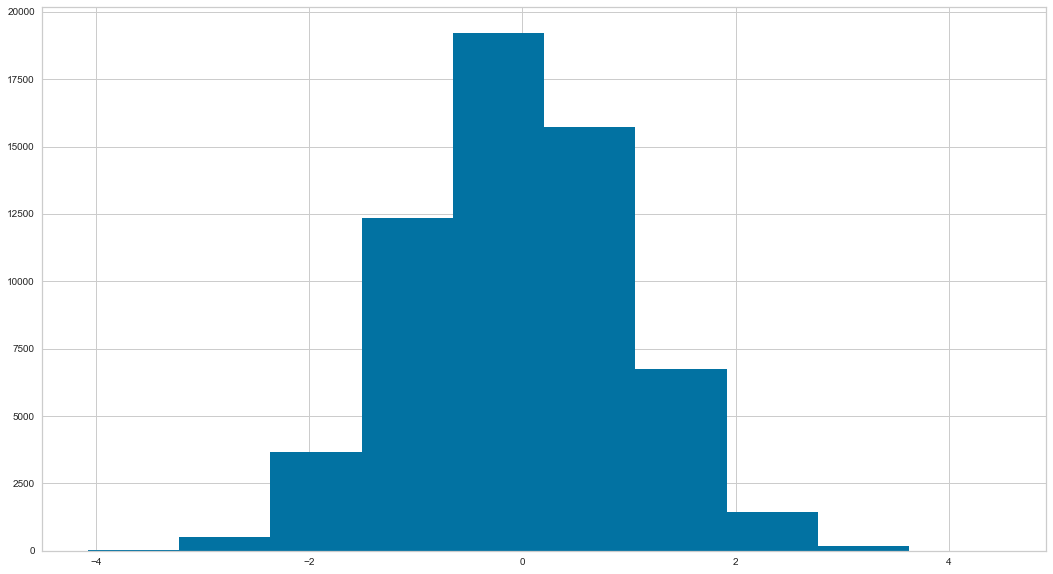

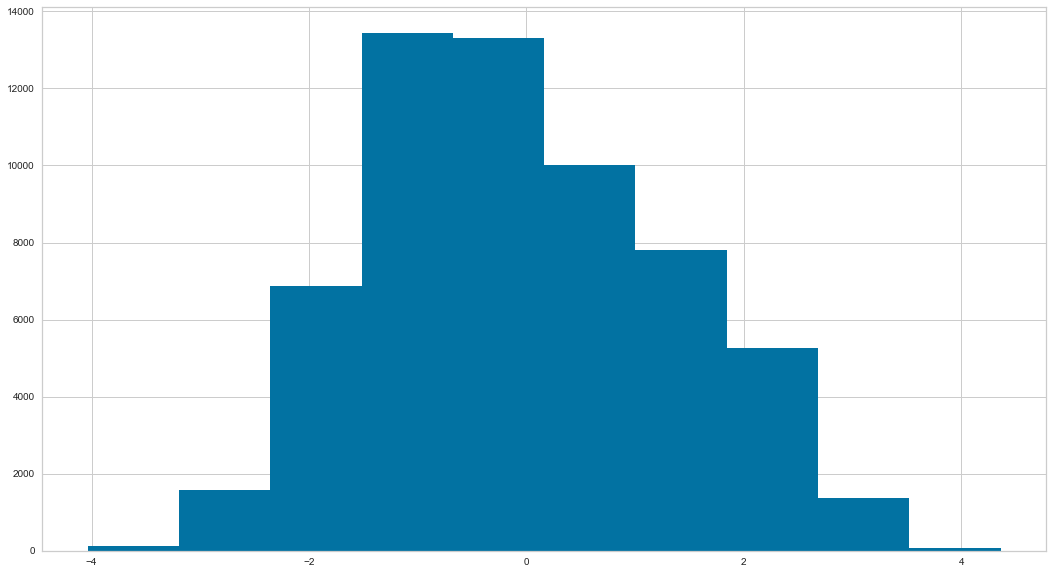

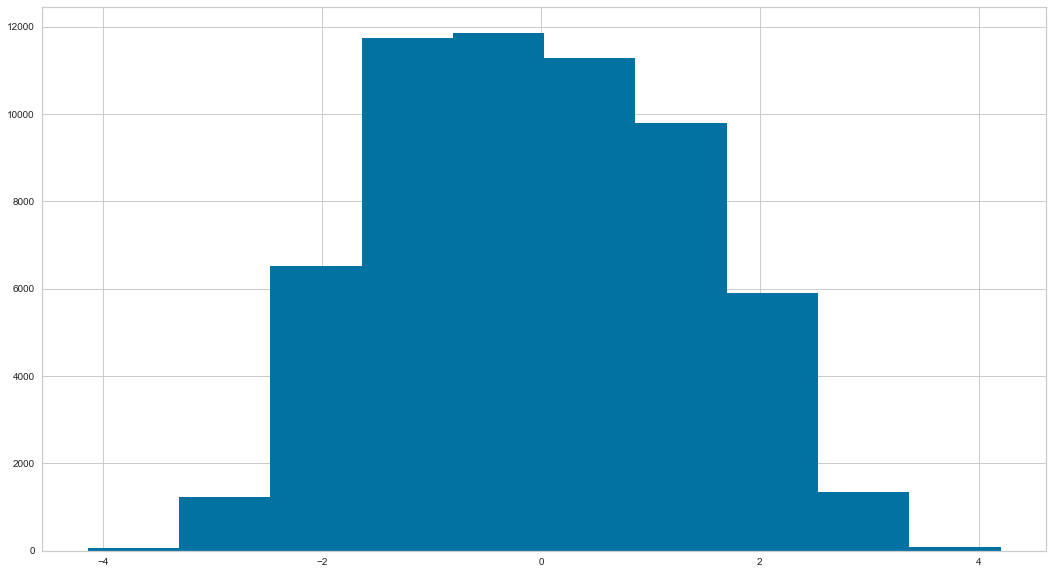

In [9]:
# dims = [3,4,7,8,9]
# for dim in dims:
#     plt.figure(figsize=(18,10))
#     df[z_col_names[dim]].hist()

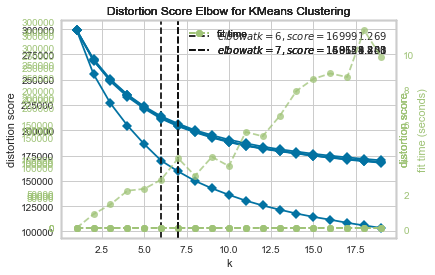

In [4]:
for run_id in run_ids :
    latent_vector = latent_vectors[run_id - 1]
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, 20))

    visualizer.fit(latent_vector)  
    visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve.jpg")

In [ ]:
num_clusters = 6

# cluster latent vectors

In [6]:
cluster_centers = []
for run_id in run_ids:
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit(latent_vectors[run_id - 1])
    cluster_centers.append(kmeans.cluster_centers_)


In [7]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=Z_DIM,
            dataset_name=DATASET_NAME)
    model.set_result_directories(log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH)

    # build graph
    model.build_model()

    # show network architecture
    show_all_variables()
    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    
    z = np.zeros([len(cluster_centers) * num_clusters, Z_DIM])
    for run_id in run_ids:
        for i in range(cluster_centers[run_id - 1].shape[0]):
            z[(run_id -  1) * num_clusters + i, :] = cluster_centers[run_id - 1][i]
        
    #decoded_images = model.decode(z)
    decoded_images = decode(model,z,BATCH_SIZE)

W0609 11:42:39.213200 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:62: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0609 11:42:39.218987 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:72: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0609 11:42:39.220111 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/tensorflow_wrappers/layers.py:35: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0609 11:42:39.312699 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:126: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0609 11:42:39.396934 140736102474624 deprecation_wrapper.py:119

---------
Variables: name (type shape) [size]
---------
encoder/en_conv1/w:0 (float32_ref 3x3x1x64) [576, bytes: 2304]
encoder/en_conv1/biases:0 (float32_ref 64) [64, bytes: 256]
encoder/en_conv2/w:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
encoder/en_conv2/biases:0 (float32_ref 128) [128, bytes: 512]
encoder/en_fc3/Matrix:0 (float32_ref 6272x32) [200704, bytes: 802816]
encoder/en_fc3/bias:0 (float32_ref 32) [32, bytes: 128]
encoder/en_fc4/Matrix:0 (float32_ref 32x10) [320, bytes: 1280]
encoder/en_fc4/bias:0 (float32_ref 10) [10, bytes: 40]
decoder/de_fc1/Matrix:0 (float32_ref 5x32) [160, bytes: 640]
decoder/de_fc1/bias:0 (float32_ref 32) [32, bytes: 128]
decoder/Linear/Matrix:0 (float32_ref 32x6272) [200704, bytes: 802816]
decoder/Linear/bias:0 (float32_ref 6272) [6272, bytes: 25088]
decoder/de_dc3/w:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
decoder/de_dc3/biases:0 (float32_ref 64) [64, bytes: 256]
decoder/de_dc4/w:0 (float32_ref 3x3x1x64) [576, bytes: 2304]
decoder/de_

<Figure size 460.8x288 with 0 Axes>

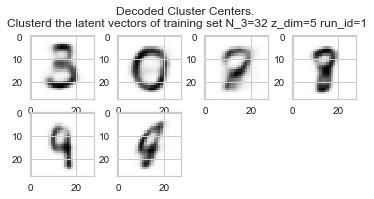

<Figure size 460.8x288 with 0 Axes>

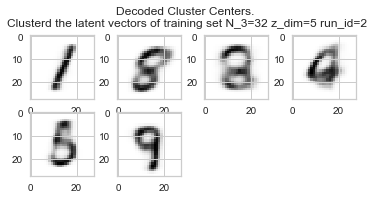

<Figure size 460.8x288 with 0 Axes>

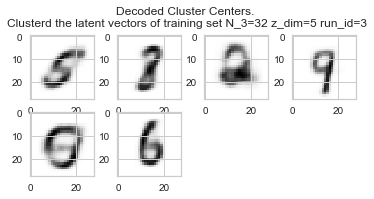

<Figure size 460.8x288 with 0 Axes>

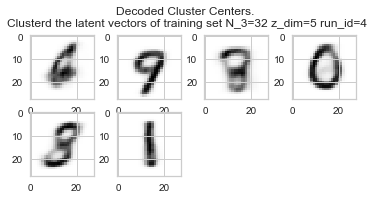

<Figure size 460.8x288 with 0 Axes>

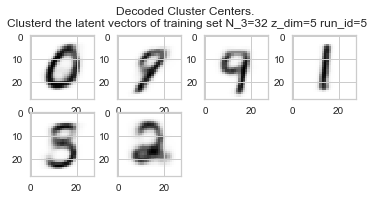

In [9]:
colormap ="Greys"
for run_id, cluster_center in enumerate(cluster_centers):
    exp_config.create_directories(run_id + 1)

    fig = plt.figure(figsize=[6.4,4])
    fig = plt.figure()
    fig.tight_layout()
    num_cols = 4
    num_rows =  math.ceil(num_clusters / num_cols)

    fig.suptitle("Decoded Cluster Centers. \nClusterd the latent vectors of training set N_3={} z_dim={} run_id={}".format(N_3,Z_DIM,run_id + 1) )

    for i in range(len(cluster_center)):
        ax = fig.add_subplot(3, num_cols, i+1)
        ax.imshow(np.squeeze(decoded_images[run_id * num_clusters + i]), cmap=colormap)
    plt.savefig(exp_config.ANALYSIS_PATH+"cluster_centers_k_{}_2.png".format(num_clusters), bbox="tight", pad_inches=0)

